# Overdetermined Beam

This example shows how to predict the behavior of a beam which is clamped at one end and
simply supported at the other end when subjected to a linear distributed load.

![](../assets/overdetermined-drawing.svg)

In [1]:
using GXBeam, LinearAlgebra

nelem = 16

# create points
L = 1
x = range(0, L, length=nelem+1)
y = zero(x)
z = zero(x)
points = [[x[i],y[i],z[i]] for i = 1:length(x)]

# index of endpoints for each beam element
start = 1:nelem
stop = 2:nelem+1

# create compliance matrix for each beam element
EI = 1e7
compliance = fill(Diagonal([0, 0, 0, 0, 1/EI, 0]), nelem)

# create assembly
assembly = Assembly(points, start, stop, compliance=compliance)

# set prescribed conditions
prescribed_conditions = Dict(
    # simply supported left endpoint
    1 => PrescribedConditions(uz=0),
    # clamped right endpoint
    nelem+1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0,
        theta_z=0)
)

# create distributed load
qmax = 1000
distributed_loads = Dict()
for i = 1:nelem
    distributed_loads[i] = DistributedLoads(assembly, i; s1=x[i],
        s2=x[i+1], fz = (s) -> qmax*s)
end

# perform a static analysis
system, converged = static_analysis(assembly;
    prescribed_conditions = prescribed_conditions,
    distributed_loads = distributed_loads,
    linear = true)

# post-process the results
state = AssemblyState(system, assembly;
    prescribed_conditions = prescribed_conditions)
nothing #hide

An analytical solution to this over-determined problem can be found using the method of
superposition using the analytical solutions to a cantilever with a linearly distributed
load and a cantilever with an end load.

In [2]:
# construct analytical solution
x_a = range(0.0, L, length=1000)
w_a = @. qmax*(1-x_a)^2/(120*EI)*(4 - 8*(1-x_a) + 5*(1-x_a)^2 - (1-x_a)^3)
slope_a = @. -qmax*(1-x_a)/(120*EI)*(8 - 24*(1-x_a) + 20*(1-x_a)^2 - 5*(1-x_a)^3)
M_a = @. qmax/120*(8 - 48*(1-x_a) + 60*(1-x_a)^2 - 20*(1-x_a)^3)

theta_a = -atan.(slope_a)

# adjust coordinate system of analytical solution
M_a = -M_a
nothing #hide

Plotting the results reveals that the analytical and computational solutions show
excellent agreement.

In [3]:
using Plots
pyplot()
nothing #hide

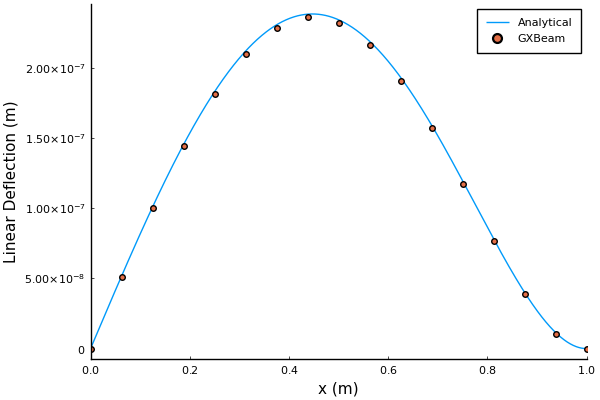

In [4]:
plot(
    xlim = (0.0, 1.0),
    xticks = 0.0:0.2:1.0,
    xlabel = "x (m)",
    ylabel = "Linear Deflection (m)",
    grid = false,
    overwrite_figure=false
    )

x = [assembly.points[ipoint][1] + state.points[ipoint].u[1] for ipoint =
    1:length(assembly.points)]
deflection = [state.points[ipoint].u[3] for ipoint = 1:length(assembly.points)]
plot!(x_a, w_a, label="Analytical")
scatter!(x, deflection, label="GXBeam")

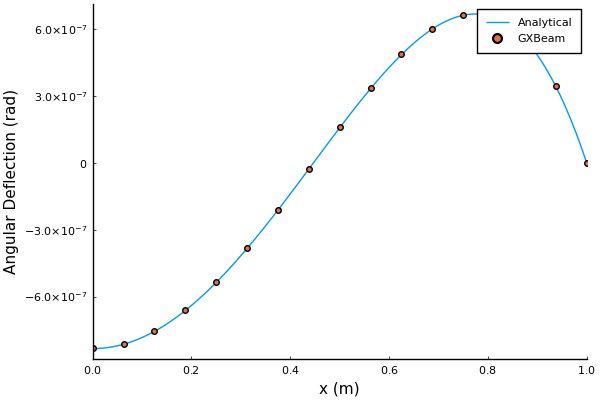

In [5]:
plot(
    xlim = (0.0, 1.0),
    xticks = 0.0:0.2:1.0,
    xlabel = "x (m)",
    ylabel = "Angular Deflection (rad)",
    grid = false,
    overwrite_figure=false
    )

x = [assembly.points[ipoint][1] + state.points[ipoint].u[1]
    for ipoint = 1:length(assembly.points)]
theta = [4*atan.(state.points[ipoint].theta[2]/4)
    for ipoint = 1:length(assembly.points)]
plot!(x_a, theta_a, label="Analytical")
scatter!(x, theta, label="GXBeam")

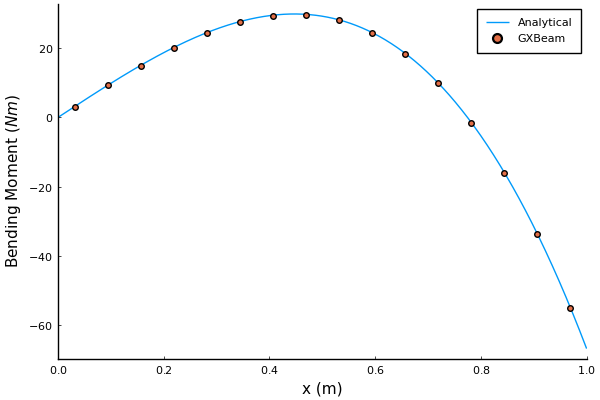

In [6]:
plot(
    xlim = (0.0, 1.0),
    xticks = 0.0:0.2:1.0,
    xlabel = "x (m)",
    ylabel = "Bending Moment (\$Nm\$)",
    grid = false,
    overwrite_figure=false
    )

x = [assembly.elements[ielem].x[1] + state.elements[ielem].u[1] for ielem =
    1:length(assembly.elements)]
M = [state.elements[ielem].M[2] for ielem = 1:length(assembly.elements)]
plot!(x_a, M_a, label="Analytical")
scatter!(x, M, label="GXBeam")

Note that we could have easily performed a nonlinear analysis for this problem by
setting `linear=false`.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*